# Garments Classification Model

## Import Requirements

In [110]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import gc
import pandas as pd

%matplotlib inline

## Import dataset

In [111]:
list_cloth_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_cloth.txt"
list_img_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_img.txt"

df_cloth=pd.read_csv(list_cloth_path,skiprows=1,delim_whitespace=True)
df_img=pd.read_csv(list_img_path,skiprows=1,delim_whitespace=True)

In [112]:
df_cloth.to_dict()
category_map = df_cloth
category_map["value"] = category_map.index + 1

In [113]:
dict_category = category_map.set_index("value").to_dict()["category_name"]
dict_cloth = category_map.set_index("category_name").to_dict()["category_type"]

In [114]:
df = df_img
df["category_label"] = df["category_label"].map(dict_category)
df["garment_type"] = df["category_label"].map(dict_cloth)

In [115]:
df["image_name"] = df["image_name"].str.replace("img/","DeepFashion_DS_IMG/")

In [116]:
df

,image_name,category_label,garment_type
0,DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse,1
1,DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,1
2,DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse,1
3,DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse,1
4,DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse,1
...,...,...,...
289217,DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000050.jpg,Dress,3
289218,DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000051.jpg,Dress,3
289219,DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000052.jpg,Dress,3
289220,DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000053.jpg,Dress,3


In [117]:
with open('../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/train.txt') as f:
    train_list = f.read().splitlines()

train_list = [row.replace("img/","DeepFashion_DS_IMG/") for row in train_list]

df[df["image_name"].isin(train_list)].drop("garment_type",axis=1).to_csv("../Dataset/DeepFashion_DS/train_list.csv",index=False)

## Image Load

In [118]:
PATH = "../Dataset/DeepFashion_DS/"
TRAINING_PATH = "train_list.csv"

data = ImageDataLoaders.from_csv(PATH, csv_fname=TRAINING_PATH,
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42), #seed=42
                                 num_workers=0)

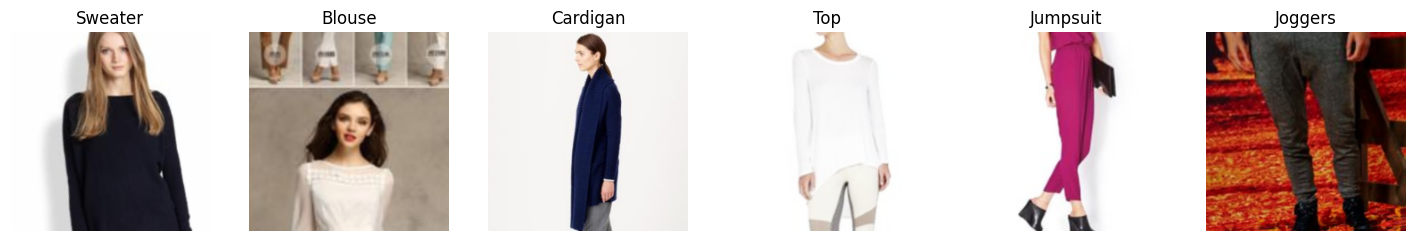

In [119]:
data.show_batch(max_n=6, nrows=1)

## Model Training

In [120]:
learn = cnn_learner(data, resnet34, metrics=[accuracy,error_rate], pretrained=True)
learn.fine_tune(3)
learn.save('stage-1_resnet34')

/home/eltrujo/Repo/fastfit_ai_fashion/FastFit_AI_env/lib/python3.8/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/eltrujo/Repo/fastfit_ai_fashion/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eltrujo/Repo/fastfit_ai_fashion/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.990396,2.029517,0.515368,0.484632,02:08


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.028986,1.608460,0.564689,0.435311,02:41
1,1.643294,1.424531,0.596140,0.403860,02:41
2,1.405901,1.388088,0.615440,0.384560,02:41


Path('../Dataset/DeepFashion_DS/models/stage-1_resnet34.pth')

In [121]:
gc.collect()
torch.cuda.empty_cache()

### Learning rate finder

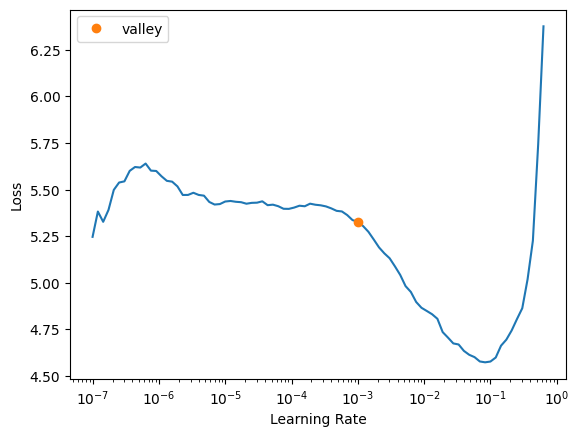

In [125]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
lr_steep = learn.lr_find()

In [128]:
lr_steep

SuggestedLRs(valley=0.0010000000474974513)

In [131]:
learn.fine_tune(4, base_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.852385,1.725795,0.538956,02:09


epoch,train_loss,valid_loss,accuracy,time
0,1.690702,1.550204,0.571837,02:42
1,1.569990,1.414441,0.596855,02:41
2,1.330987,1.325479,0.639028,02:47
3,1.058336,1.323872,0.641887,02:45


### Discriminative Learning Rates

In [132]:
learn.unfreeze()

SuggestedLRs(valley=9.999999747378752e-06)

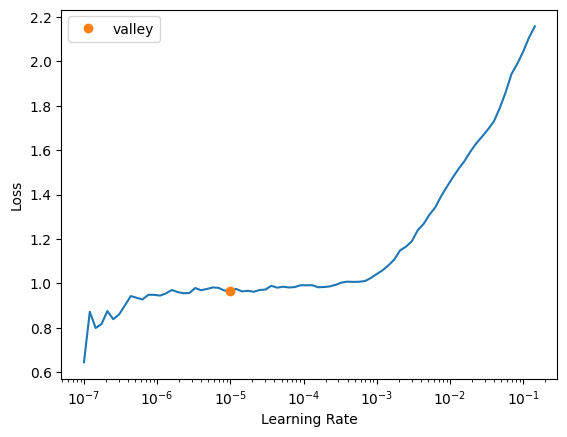

In [133]:
learn.lr_find()

In [134]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.989079,1.347412,0.636169,02:42
1,0.972968,1.367776,0.644746,02:28
2,0.911100,1.371304,0.646176,02:28
3,0.881187,1.390661,0.646176,02:27
4,0.822013,1.394973,0.644746,02:27
5,0.806997,1.407971,0.643317,02:27


### NAdam Optimizer

In [ ]:
# https://github.com/Rakeshsuku/Medium-Blog/blob/master/Understanding%20FastAI%20v2%20Training/Part2_Optimizers.ipynb

### Export model

In [135]:
modelname = learn.model
modelname.cpu()
torch.save(modelname, 'stage-1_resnet34.pkl')

## Evaluation